In [1]:
import shutil
import os
import json
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def load_segment_image(file_path):
    """
    Load a segment image and convert it to a numpy array.
    
    Parameters:
    - file_path: path to the segment image
    
    Returns:
    - numpy array of the segment image
    """
    image = Image.open(file_path)
    return np.array(image)

def get_segment_name(segment_image, x, y):
    """
    segment_image에서 (x, y) 좌표에 있는 픽셀의 세그먼트 이름을 반환합니다.
    
    Parameters:
    - segment_image: 2D numpy array of segment indices
    - x: x coordinate of the pixel
    - y: y coordinate of the pixel
    
    Returns:
    - 세그먼트 이름 (string)
    """
    segment_index = segment_image[y, x]
    return index_to_segment.get(segment_index, "Unknown")

def process_segment_directory(file_path,x,y):
    """
    주어진 디렉토리 내의 모든 segment 이미지를 처리합니다.
    
    Parameters:
    - directory: path to the directory containing segment images
    """
    
    segment_image = load_segment_image(file_path)
    filename = os.path.basename(file_path)
    # 예시로 (10, 10) 좌표의 세그먼트 이름을 출력합니다.
    segment_name = get_segment_name(segment_image, x, y)
    # print(f"File: {filename} - Pixel at ({x}, {y}) belongs to segment: {segment_name}")
    
    return segment_name

In [3]:
def denormalize_point(point, img_width, img_height):
    """
    Denormalize a point from normalized coordinates to image coordinates.
    
    Args:
    point (tuple): Normalized (x, y) coordinates.
    img_width (int): Width of the image.
    img_height (int): Height of the image.
    
    Returns:
    tuple: Denormalized (x, y) coordinates.
    """
    x, y = point
    return (x * img_width, y * img_height)

def calculate_eye_width(landmarks, img_width, img_height):
    """
    Calculate the width of both eyes based on normalized facial landmarks.
    
    Args:
    landmarks (dict): Dictionary containing facial landmarks with normalized (x, y) coordinates.
    img_width (int): Width of the image.
    img_height (int): Height of the image.
    
    Returns:
    dict: Dictionary containing the width of the left and right eyes.
    """
    left_eye_indices = [36, 39]  # Indices for the left eye corners
    right_eye_indices = [42, 45]  # Indices for the right eye corners
    
    # Extract and denormalize left eye corners
    left_eye_start = denormalize_point(landmarks[f'{left_eye_indices[0]}'], img_width, img_height)
    left_eye_end = denormalize_point(landmarks[f'{left_eye_indices[1]}'], img_width, img_height)
    
    # Extract and denormalize right eye corners
    right_eye_start = denormalize_point(landmarks[f'{right_eye_indices[0]}'], img_width, img_height)
    right_eye_end = denormalize_point(landmarks[f'{right_eye_indices[1]}'], img_width, img_height)
    
    # Calculate distance between the corners for each eye
    left_eye_width = math.sqrt((left_eye_end[0] - left_eye_start[0])**2 + (left_eye_end[1] - left_eye_start[1])**2)
    right_eye_width = math.sqrt((right_eye_end[0] - right_eye_start[0])**2 + (right_eye_end[1] - right_eye_start[1])**2)
    
    return left_eye_width, right_eye_width

In [4]:
def determine_eye_seen(row):
    if row['left_eye_width'] > 10 and row['right_eye_width'] > 10:
        return 'useful'
    elif row['left_eye_width'] < 10 and row['right_eye_width'] < 10:
        return 'useless'
    else:
        return 'consider'

def determine_lens_seen(row):
    if row['lens_color'] == "default":
        if row['transparency'] >= 0.7:
            return "useful"
        else:
            return "useless"
    else:
            return "useless"
        
def determine_headwear_seen(row):
    if 'headwear' in row['left_center_seg'] or 'headwear' in row['right_center_seg']:
        return "useless"
    else:
        return "useful"

In [5]:
def angle_range(row):
    if abs(row['roll']) >= 15:
        if abs(row['pitch']) >= 20 and abs(row['yaw']) >= 20:
            return 1
        elif abs(row['pitch']) < 20 and abs(row['yaw']) <20:
            return 3
        else:
            return 2
    else:
        if abs(row['pitch']) >= 20 and abs(row['yaw']) >= 20:
            return 2
        elif abs(row['pitch']) < 20 and abs(row['yaw']) <20:
            return 4
        else:
            return 3
    

In [6]:
def determine_final_seen(row):
    if row['eye_seen'] == "useless" or row['lens_seen'] == "useless" or row['headwear_seen'] == "useless" or (row['right_center_seg_seen'] != 'eyes' and row['left_center_seg_seen'] != 'eyes'):
        return "useless"
    else:
        return "useful"

In [7]:
def determine_right_center_seg_seen(row):
    right_center_seg = row['right_center_seg']
    # 단어가 포함된 경우
    if right_center_seg == 'headwear':
        return 'headwear'
    elif any(seg in right_center_seg for seg in ['finger', 'hand','nail']):
        return "hand"
    elif any(seg in right_center_seg for seg in ['eye', 'orbit','sclera','iris','caruncle','cornea','pupil']):
        return "eyes"
    elif any(seg in right_center_seg for seg in ['brow','temples','cheek','nose','jaw','head','ear','nostrils','jowl','smile','chin','mouth','lip','mustache']):
        return "face"
    elif any(seg in right_center_seg for seg in ['arm','leg','nape','neck','torso','shoulder']):
        return "body"
    elif any(seg in right_center_seg for seg in ['smart']):
        return "smartphone"  
    elif 'glasses' in right_center_seg:
        return 'glasses'
    return right_center_seg

def determine_left_center_seg_seen(row):
    left_center_seg = row['left_center_seg']
    # 단어가 포함된 경우
    if left_center_seg == 'headwear':
        return 'headwear'
    elif any(seg in left_center_seg for seg in ['finger', 'hand','nail']):
        return "hand"
    elif any(seg in left_center_seg for seg in ['eye', 'orbit','sclera','iris','caruncle','cornea','pupil']):
        return "eyes"
    elif any(seg in left_center_seg for seg in ['brow','temples','cheek','nose','jaw','head','ear','nostrils','jowl','smile','chin','mouth','lip','mustache']):
        return "face"
    elif any(seg in left_center_seg for seg in ['arm','leg','nape','neck','torso','shoulder']):
        return "body"
    elif any(seg in left_center_seg for seg in ['smart']):
        return "smartphone"  
    elif 'glasses' in left_center_seg:
        return 'glasses'
    return left_center_seg

In [8]:
id_list = os.listdir('Z:\\SAI\\data\\IR\\labeldata\\')

In [9]:
results = []

for id_ in id_list:
    print(id_)
    img_dir = f'Z:\\SAI\\data\\IR\\rawdata\\{id_}'
    label_dir = f'Z:\\SAI\\data\\IR\\labeldata\\{id_}'
    seg_dir = f'Z:\\SAI\\data\\IR\\segdata\\{id_}'
    for label_file in os.listdir(label_dir):
        
        label = os.path.join(label_dir,label_file)
        img_file = label_file.replace('.info.json','.rgb.png')
        img_path = os.path.join(img_dir,img_file)
        seg_file = label_file.replace('.info.json','.segments.png')
        seg_path = os.path.join(seg_dir,seg_file)
        image = cv2.imread(img_path)

        with open(label,  'r', encoding='utf-8') as f:
            data = json.load(f)

        landmarks = data["landmarks"]["ibug68"]
        # print(landmarks)
        
        segments_mapping = data["segments_mapping"]
        lens_color = data["accessories"]["glasses"]["lens_color"]
        transparency = data["accessories"]["glasses"]["transparency"]
        metalness = data["accessories"]["glasses"]["metalness"]
        roll = data['facial_attributes']['head_turn']['roll']
        pitch = data['facial_attributes']['head_turn']['pitch']
        yaw = data['facial_attributes']['head_turn']['yaw']
        whole_body = data['landmarks']["coco"]["whole_body"]
        # print(segments_mapping)
        index_to_segment = {v: k for k, v in segments_mapping.items()}

        # 화면 좌표를 저장할 리스트 초기화
        screen_space_positions = {}

        for name, landmark in enumerate(landmarks):
            
            screen_space_pos = landmark["screen_space_pos"]
            screen_space_positions[f'{name}'] = screen_space_pos
            # print(screen_space_positions)
            # print(landmarks[36])

        try:
            h, w, _ = image.shape
        except:
            print(img_path)

        # print(h,w)
        
        point_6 = None
        point_7 = None
        point_12 = None
        point_13 = None

        for item in whole_body:
            if item["name"] == "6":
                point_6 = item["world_space_pos"]
            elif item["name"] == "7":
                point_7 = item["world_space_pos"]
            elif item["name"] == "12":
                point_12 = item["world_space_pos"]
            elif item["name"] == "13":
                point_13 = item["world_space_pos"]

        # 벡터 계산
        vector_u = np.array(point_7) - np.array(point_6)
        vector_v = np.array(point_13) - np.array(point_12)

        # 내적 계산
        dot_product = np.dot(vector_u, vector_v)

        # 벡터 크기 계산
        magnitude_u = np.linalg.norm(vector_u)
        magnitude_v = np.linalg.norm(vector_v)

        # 각도 계산
        cos_theta = dot_product / (magnitude_u * magnitude_v)
        theta = np.arccos(cos_theta)

        # 라디안에서 각도로 변환
        angle_degrees = np.degrees(theta)
       
        if len(screen_space_positions) < 68:
            print(label_file)
        ca_wi = {}

        ca_wi['id'] = id_
        ca_wi['left_eye_width'],ca_wi['right_eye_width'] = calculate_eye_width(screen_space_positions, w, h)
        ca_wi['label_file'] = label  # Add label file name to results
        ca_wi['img_path'] = img_path  # Add image path to results
        left_center_x = int(((screen_space_positions['43'][0]*w)+(screen_space_positions['46'][0]*w))/2)
        left_center_y = int(((screen_space_positions['43'][1]*h)+(screen_space_positions['46'][1]*h))/2)
        ca_wi['left_center_landmark'] = (left_center_x,left_center_y)
        right_center_x = int(((screen_space_positions['37'][0]*w)+(screen_space_positions['40'][0]*w))/2)
        right_center_y = int(((screen_space_positions['37'][1]*h)+(screen_space_positions['40'][1]*h))/2)
        ca_wi['right_center_landmark'] = (right_center_x,right_center_y)
        
        left_center_seg = process_segment_directory(seg_path,left_center_x,left_center_y)
        right_center_seg = process_segment_directory(seg_path,right_center_x,right_center_y)

        ca_wi['lens_color'] = lens_color
        ca_wi['left_center_seg'] = left_center_seg
        ca_wi['right_center_seg'] = right_center_seg
        ca_wi['transparency'] = transparency
        ca_wi['metalness'] = metalness
        ca_wi['angle_degrees'] = angle_degrees
        ca_wi['roll'] = roll
        ca_wi['pitch'] = pitch
        ca_wi['yaw'] = yaw

        results.append(ca_wi)
        
    df = pd.DataFrame(results)

id_00


KeyboardInterrupt: 

In [12]:
df1 = df

In [13]:
df1

,id,left_eye_width,right_eye_width,label_file,img_path,left_center_landmark,right_center_landmark,lens_color,left_center_seg,right_center_seg,transparency,metalness,angle_degrees,roll,pitch,yaw
0,id_00,24.139097,25.429866,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_0....,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_0.ca...,"(960, 143)","(897, 135)",black,glasses_lens_left,glasses_lens_right,0.068196,1,12.261975,-18.666569,22.616575,-28.333848
1,id_00,24.229116,11.523599,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_1....,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_1.ca...,"(930, 76)","(886, 84)",black,nose,iris_right,0.009939,1,23.388163,-15.725627,38.063109,-22.350858
2,id_00,23.711309,19.504546,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_10...,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_10.c...,"(965, 141)","(914, 123)",black,glasses_lens_left,glasses_lens_right,0.071288,0,12.530238,-27.937463,29.255204,-22.769429
3,id_00,20.590328,21.830804,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_11...,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_11.c...,"(852, 100)","(808, 126)",default,finger1_mid_bottom_right,arm_lower_right,0.792524,0,23.250010,-18.364759,35.399582,-37.564134
4,id_00,8.474383,20.629281,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_12...,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_12.c...,"(932, 108)","(905, 88)",black,glasses_lens_left,glasses_lens_right,0.099539,1,13.910319,-20.415922,35.234555,-24.143186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40886,id_20,21.616853,17.858179,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_5....,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_5.ca...,"(947, 199)","(915, 231)",default,hair,hair,0.717617,1,7.588121,29.648928,-25.330860,32.945143
40887,id_20,17.946295,17.052367,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_6....,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_6.ca...,"(959, 223)","(930, 251)",black,headwear,headwear,0.882100,1,22.249049,19.910238,-26.012001,33.515968
40888,id_20,12.042559,14.005265,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_7....,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_7.ca...,"(947, 200)","(973, 214)",black,hair,hair,0.742859,0,10.359903,17.110897,-28.354484,34.638128
40889,id_20,17.966413,13.995988,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_8....,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_8.ca...,"(924, 166)","(900, 193)",default,brow,eyelashes_right,1.000000,0,14.753031,26.146206,-23.969788,22.422888


In [14]:
df1['eye_seen'] = df1.apply(determine_eye_seen, axis=1)
df1['lens_seen'] = df1.apply(determine_lens_seen, axis=1)
df1['headwear_seen'] = df1.apply(determine_headwear_seen, axis=1)

In [15]:
df1['right_center_seg_seen'] = df1.apply(determine_right_center_seg_seen, axis=1)
df1['left_center_seg_seen'] = df1.apply(determine_left_center_seg_seen, axis=1)

In [16]:
df1['final_seen'] = df1.apply(determine_final_seen, axis=1)

In [19]:
df1_id_0 = df1[df1['id'] == 'id_00']
df1_id_1 = df1[df1['id'] == 'id_01']
df1_id_2 = df1[df1['id'] == 'id_02']

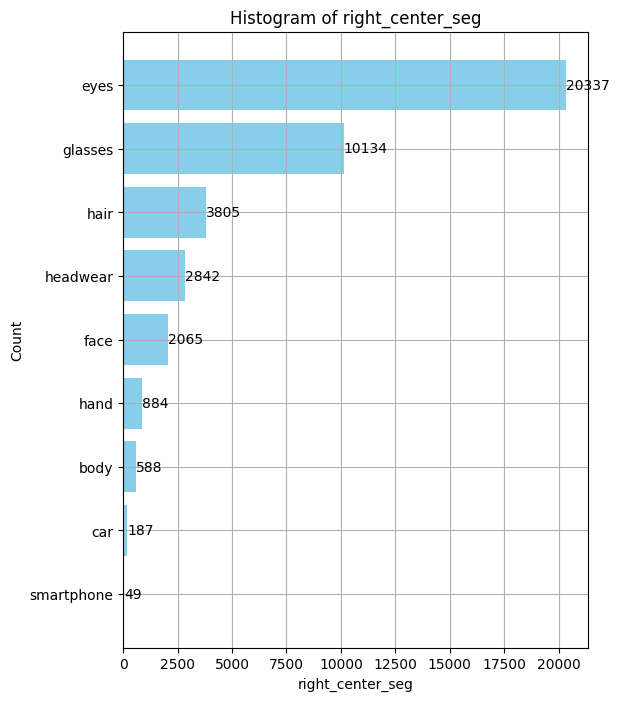

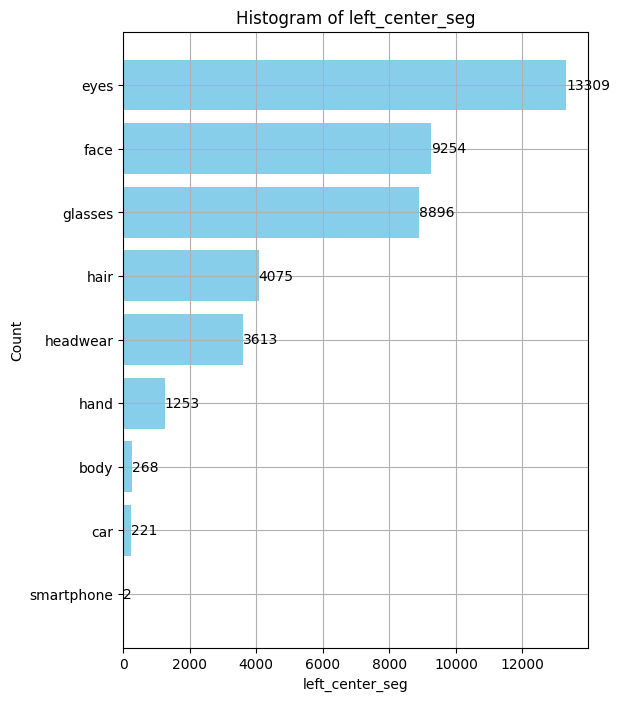

In [17]:
seen_countsT = df1['right_center_seg_seen'].value_counts()


# 히스토그램 그리기
plt.figure(figsize=(6, 8))
bars = plt.barh(seen_countsT.index, seen_countsT.values, color='skyblue')
plt.xlabel('right_center_seg')
plt.ylabel('Count')
plt.title('Histogram of right_center_seg')
plt.grid(True)

# y축 리버스
plt.gca().invert_yaxis()

# 각 막대 위에 빈도 값 표시
for bar, count in zip(bars, seen_countsT.values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(count), ha='left', va='center')

plt.show()

seen_countsT = df1['left_center_seg_seen'].value_counts()

# 히스토그램 그리기
plt.figure(figsize=(6, 8))
bars = plt.barh(seen_countsT.index, seen_countsT.values, color='skyblue')
plt.xlabel('left_center_seg')
plt.ylabel('Count')
plt.title('Histogram of left_center_seg')
plt.grid(True)

# y축 리버스
plt.gca().invert_yaxis()

# 각 막대 위에 빈도 값 표시
for bar, count in zip(bars, seen_countsT.values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(count), ha='left', va='center')

plt.show()

In [18]:
# 데이터의 빈도 계산
seen_counts0 = df1_id_0['right_center_seg_seen'].value_counts()
seen_counts1 = df1_id_1['right_center_seg_seen'].value_counts()
seen_counts2 = df1_id_2['right_center_seg_seen'].value_counts()
categories = ['eyes', 'face','headwear', 'glasses', 'hair','hand','car','body','smartphone']

# 빈도 리스트 생성
counts0 = [seen_counts0.get(cat, 0) for cat in categories]
counts1 = [seen_counts1.get(cat, 0) for cat in categories]
counts2 = [seen_counts2.get(cat, 0) for cat in categories]

bar_height = 0.35
index = np.arange(len(categories))

# 히스토그램 그리기
plt.figure(figsize=(6, 10))
bars0 = plt.barh(index - bar_height/3, counts0, bar_height/3, label='id_00', color='skyblue')
bars1 = plt.barh(index, counts1, bar_height/3, label='id_01', color='lightgreen')
bars2 = plt.barh(index + bar_height/3, counts2, bar_height/3, label='id_02', color='pink')

# 그래프 꾸미기
plt.xlabel('Count')
plt.ylabel('right_center_seg')
plt.title('Histogram of right_center_seg_seen by id')
plt.yticks(index, categories)
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.legend()

# 각 막대 위에 값 표시
for bars in [bars0, bars1, bars2]:
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()*2/3, str(int(width)), ha='left', va='center')

plt.show()

bar_height = 0.35
index = np.arange(len(categories))

# 히스토그램 그리기
plt.figure(figsize=(6, 8))
bars0 = plt.barh(index - bar_height/3, counts0, bar_height/3, label='id_00', color='skyblue')
bars1 = plt.barh(index , counts1, bar_height/3, label='id_01', color='lightgreen')
bars2 = plt.barh(index + bar_height/3, counts2, bar_height/3, label='id_02', color='pink')

# 그래프 꾸미기
plt.xlabel('Count')
plt.ylabel('left_center_seg_seen')
plt.title('Histogram of left_center_seg_seen by id')
plt.yticks(index, categories)
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.legend()

# 각 막대 위에 값 표시
for bars in [bars0, bars1, bars2]:
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/3, str(int(width)), ha='left', va='center')

plt.show()

NameError: name 'df1_id_0' is not defined

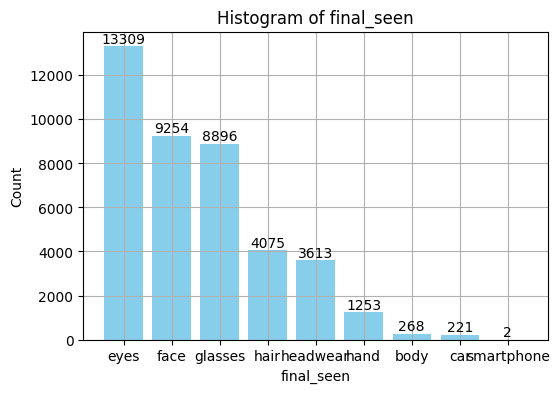

In [19]:
# seen_countsT = df1['final_seen'].value_counts()
# seen_counts0 = df1_id_0['final_seen'].value_counts()
# seen_counts1 = df1_id_1['final_seen'].value_counts()
# seen_counts2 = df1_id_2['final_seen'].value_counts()
# categories = ['useful', 'useless']

# # 빈도 리스트 생성
# counts0 = [seen_counts0.get(cat, 0) for cat in categories]
# counts1 = [seen_counts1.get(cat, 0) for cat in categories]
# counts2 = [seen_counts2.get(cat, 0) for cat in categories]


# bar_width = 0.35
# index = np.arange(len(categories))

# 히스토그램 그리기
plt.figure(figsize=(6, 4))
bars = plt.bar(seen_countsT.index, seen_countsT.values, color='skyblue')
plt.xlabel('final_seen')
plt.ylabel('Count')
plt.title('Histogram of final_seen')
plt.grid(True)

for bar, count in zip(bars, seen_countsT.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom')
plt.show()

# # 히스토그램 그리기
# plt.figure(figsize=(6, 4))
# bars0 = plt.bar(index - bar_width/3, counts0, bar_width/3, label='id_00', color='skyblue')
# bars1 = plt.bar(index , counts1, bar_width/3, label='id_01', color='lightgreen')
# bars2 = plt.bar(index + bar_width/3, counts2, bar_width/3, label='id_02', color='pink')

# # 그래프 꾸미기
# plt.xlabel('final_seen')
# plt.ylabel('Count')
# plt.title('Histogram of final_seen by id')
# plt.xticks(index, categories)
# plt.grid(True)
# plt.legend()

# # 각 막대 위에 값 표시
# for bars in [bars0, bars1, bars2]:
#     for bar in bars:
#         height = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2, height, str(int(height)), ha='center', va='bottom')

# plt.show()

In [20]:
df_useless = df1[(df1['final_seen'] == 'useless')]

In [21]:
df_useless

,id,left_eye_width,right_eye_width,label_file,img_path,left_center_landmark,right_center_landmark,lens_color,left_center_seg,right_center_seg,...,angle_degrees,roll,pitch,yaw,eye_seen,lens_seen,headwear_seen,right_center_seg_seen,left_center_seg_seen,final_seen
0,id_00,24.139097,25.429866,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_0....,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_0.ca...,"(960, 143)","(897, 135)",black,glasses_lens_left,glasses_lens_right,...,12.261975,-18.666569,22.616575,-28.333848,useful,useless,useful,glasses,glasses,useless
1,id_00,24.229116,11.523599,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_1....,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_1.ca...,"(930, 76)","(886, 84)",black,nose,iris_right,...,23.388163,-15.725627,38.063109,-22.350858,useful,useless,useful,eyes,face,useless
2,id_00,23.711309,19.504546,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_10...,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_10.c...,"(965, 141)","(914, 123)",black,glasses_lens_left,glasses_lens_right,...,12.530238,-27.937463,29.255204,-22.769429,useful,useless,useful,glasses,glasses,useless
3,id_00,20.590328,21.830804,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_11...,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_11.c...,"(852, 100)","(808, 126)",default,finger1_mid_bottom_right,arm_lower_right,...,23.250010,-18.364759,35.399582,-37.564134,useful,useful,useful,body,hand,useless
4,id_00,8.474383,20.629281,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_12...,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_12.c...,"(932, 108)","(905, 88)",black,glasses_lens_left,glasses_lens_right,...,13.910319,-20.415922,35.234555,-24.143186,consider,useless,useful,glasses,glasses,useless
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40884,id_20,19.345396,23.056083,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_3....,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_3.ca...,"(947, 335)","(902, 352)",default,hair,hair,...,9.811237,19.882979,-25.845902,37.532039,useful,useful,useful,hair,hair,useless
40886,id_20,21.616853,17.858179,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_5....,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_5.ca...,"(947, 199)","(915, 231)",default,hair,hair,...,7.588121,29.648928,-25.330860,32.945143,useful,useful,useful,hair,hair,useless
40887,id_20,17.946295,17.052367,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_6....,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_6.ca...,"(959, 223)","(930, 251)",black,headwear,headwear,...,22.249049,19.910238,-26.012001,33.515968,useful,useless,useless,headwear,headwear,useless
40888,id_20,12.042559,14.005265,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_7....,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_7.ca...,"(947, 200)","(973, 214)",black,hair,hair,...,10.359903,17.110897,-28.354484,34.638128,useful,useless,useful,hair,hair,useless


In [28]:
df1.value_counts(subset=['final_seen'])

final_seen
useless       22457
useful        18434
dtype: int64

In [22]:
import seaborn as sns

C:\Users\KJLEE\AppData\Local\Temp\ipykernel_8616\2849490150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_useless['roll_bin'] = pd.cut(df_useless['roll'], bins=[-30, -20, -10, 0, 10, 20, 30])
C:\Users\KJLEE\AppData\Local\Temp\ipykernel_8616\2849490150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_useless['pitch_bin'] = pd.cut(df_useless['pitch'], bins=[-40, -30, -20, -10, 0, 10, 20, 30, 40])
C:\Users\KJLEE\AppData\Local\Temp\ipykernel_8616\2849490150.py:4: SettingWithCopyWarning: 
A value 

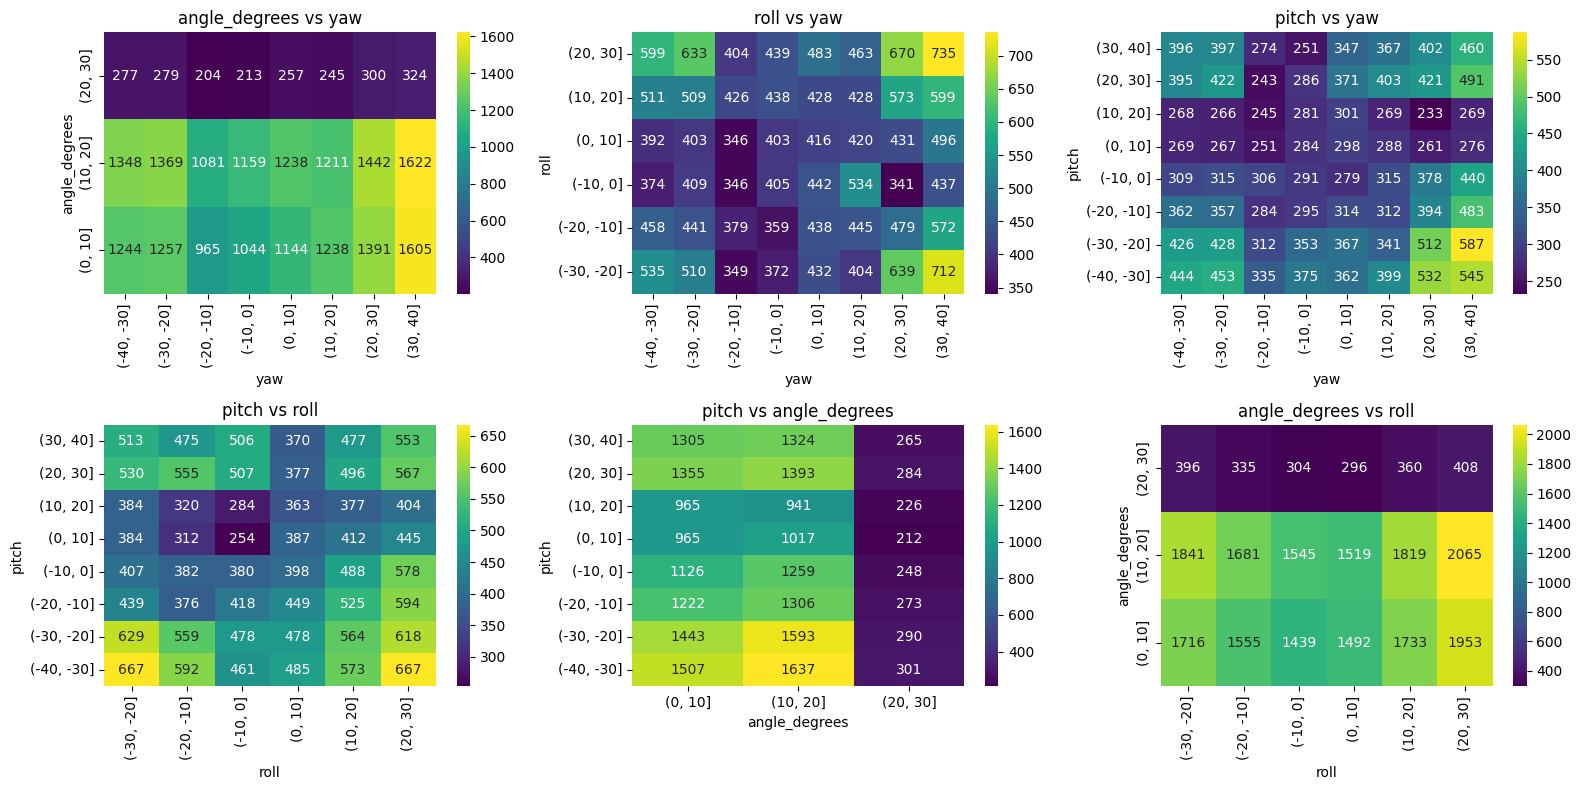

22457


In [23]:
# 변수들을 구간으로 나누기
df_useless['roll_bin'] = pd.cut(df_useless['roll'], bins=[-30, -20, -10, 0, 10, 20, 30])
df_useless['pitch_bin'] = pd.cut(df_useless['pitch'], bins=[-40, -30, -20, -10, 0, 10, 20, 30, 40])
df_useless['yaw_bin'] = pd.cut(df_useless['yaw'], bins=[-40, -30, -20, -10, 0, 10, 20, 30, 40])
df_useless['angle_degrees_bin'] = pd.cut(df_useless['angle_degrees'], bins=[0, 10, 20, 30])

# 각 독립 변수와 종속 변수의 관계 시각화
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 5)
heatmap_data = pd.crosstab(df_useless['pitch_bin'], df_useless['angle_degrees_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('angle_degrees')
plt.ylabel('pitch')
plt.gca().invert_yaxis()
plt.title('pitch vs angle_degrees')

plt.subplot(2, 3, 2)
heatmap_data = pd.crosstab(df_useless['roll_bin'], df_useless['yaw_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('yaw')
plt.ylabel('roll')
plt.gca().invert_yaxis()
plt.title('roll vs yaw')

plt.subplot(2, 3, 3)
heatmap_data = pd.crosstab(df_useless['pitch_bin'], df_useless['yaw_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('yaw')
plt.ylabel('pitch')
plt.gca().invert_yaxis()
plt.title('pitch vs yaw')

plt.subplot(2, 3, 1)
heatmap_data = pd.crosstab(df_useless['angle_degrees_bin'], df_useless['yaw_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('yaw')
plt.ylabel('angle_degrees')
plt.gca().invert_yaxis()
plt.title('angle_degrees vs yaw')

plt.subplot(2, 3, 4)
heatmap_data = pd.crosstab(df_useless['pitch_bin'], df_useless['roll_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('roll')
plt.ylabel('pitch')
plt.gca().invert_yaxis()
plt.title('pitch vs roll')

plt.subplot(2, 3, 6)
heatmap_data = pd.crosstab(df_useless['angle_degrees_bin'], df_useless['roll_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('roll')
plt.ylabel('angle_degrees')
plt.gca().invert_yaxis()
plt.title('angle_degrees vs roll')

plt.tight_layout()
plt.show()

print(len(df_useless))

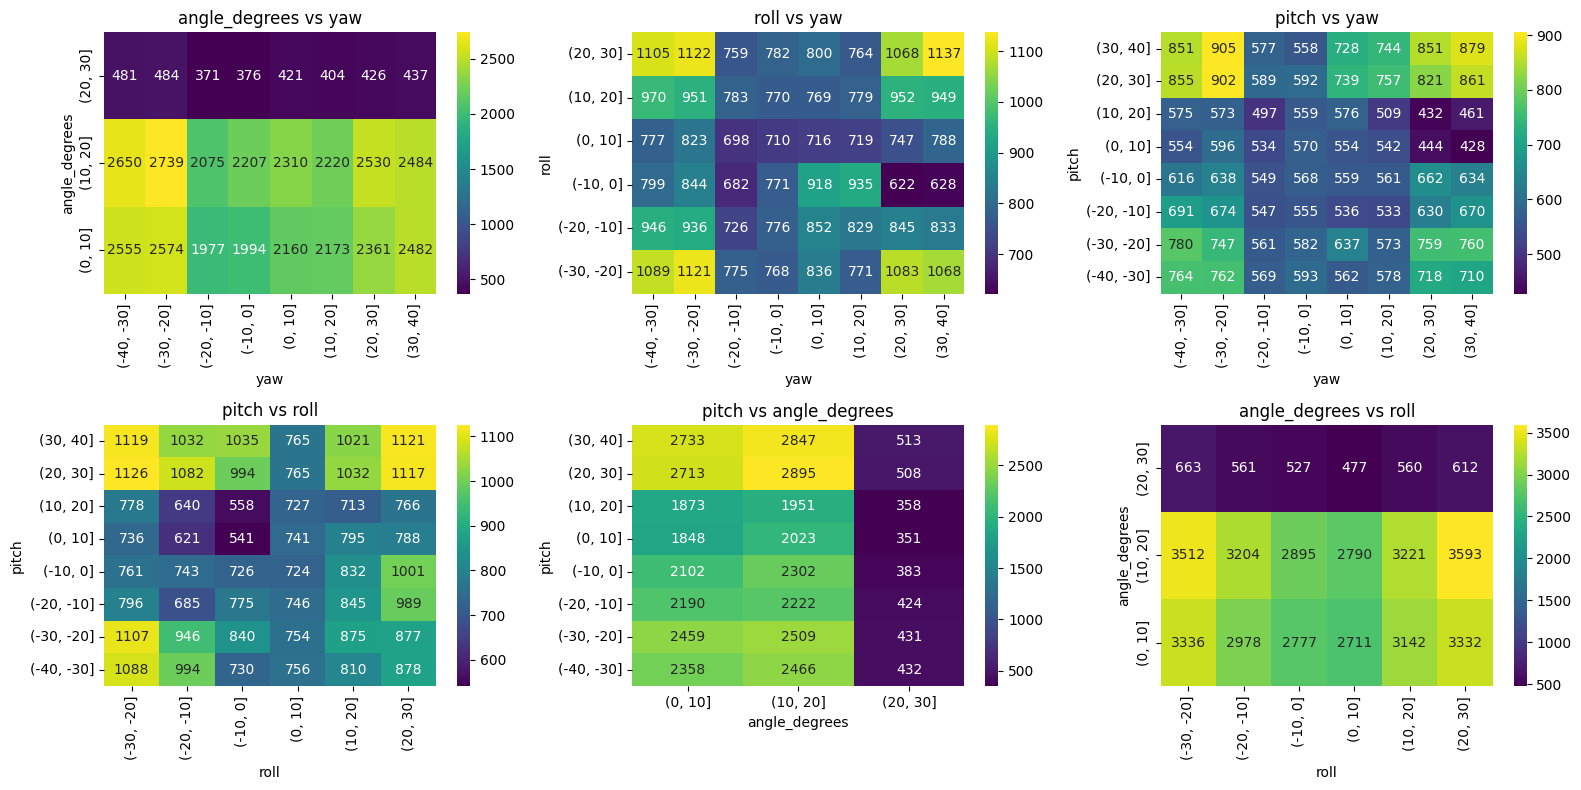

In [29]:
# 변수들을 구간으로 나누기
df1['roll_bin'] = pd.cut(df1['roll'], bins=[-30, -20, -10, 0, 10, 20, 30])
df1['pitch_bin'] = pd.cut(df1['pitch'], bins=[-40, -30, -20, -10, 0, 10, 20, 30, 40])
df1['yaw_bin'] = pd.cut(df1['yaw'], bins=[-40, -30, -20, -10, 0, 10, 20, 30, 40])
df1['angle_degrees_bin'] = pd.cut(df1['angle_degrees'], bins=[0, 10, 20, 30])

# 각 독립 변수와 종속 변수의 관계 시각화
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 5)
heatmap_data = pd.crosstab(df1['pitch_bin'], df1['angle_degrees_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('angle_degrees')
plt.ylabel('pitch')
plt.gca().invert_yaxis()
plt.title('pitch vs angle_degrees')

plt.subplot(2, 3, 2)
heatmap_data = pd.crosstab(df1['roll_bin'], df1['yaw_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('yaw')
plt.ylabel('roll')
plt.gca().invert_yaxis()
plt.title('roll vs yaw')

plt.subplot(2, 3, 3)
heatmap_data = pd.crosstab(df1['pitch_bin'], df1['yaw_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('yaw')
plt.ylabel('pitch')
plt.gca().invert_yaxis()
plt.title('pitch vs yaw')

plt.subplot(2, 3, 1)
heatmap_data = pd.crosstab(df1['angle_degrees_bin'], df1['yaw_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('yaw')
plt.ylabel('angle_degrees')
plt.gca().invert_yaxis()
plt.title('angle_degrees vs yaw')

plt.subplot(2, 3, 4)
heatmap_data = pd.crosstab(df1['pitch_bin'], df1['roll_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('roll')
plt.ylabel('pitch')
plt.gca().invert_yaxis()
plt.title('pitch vs roll')

plt.subplot(2, 3, 6)
heatmap_data = pd.crosstab(df1['angle_degrees_bin'], df1['roll_bin'])
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.xlabel('roll')
plt.ylabel('angle_degrees')
plt.gca().invert_yaxis()
plt.title('angle_degrees vs roll')

plt.tight_layout()
plt.show()

In [25]:
df1[df1['lens_seen'] == 'useless']

,id,left_eye_width,right_eye_width,label_file,img_path,left_center_landmark,right_center_landmark,lens_color,left_center_seg,right_center_seg,...,eye_seen,lens_seen,headwear_seen,right_center_seg_seen,left_center_seg_seen,final_seen,roll_bin,pitch_bin,yaw_bin,angle_degrees_bin
0,id_00,24.139097,25.429866,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_0....,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_0.ca...,"(960, 143)","(897, 135)",black,glasses_lens_left,glasses_lens_right,...,useful,useless,useful,glasses,glasses,useless,"(-20, -10]","(20, 30]","(-30, -20]","(10, 20]"
1,id_00,24.229116,11.523599,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_1....,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_1.ca...,"(930, 76)","(886, 84)",black,nose,iris_right,...,useful,useless,useful,eyes,face,useless,"(-20, -10]","(30, 40]","(-30, -20]","(20, 30]"
2,id_00,23.711309,19.504546,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_10...,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_10.c...,"(965, 141)","(914, 123)",black,glasses_lens_left,glasses_lens_right,...,useful,useless,useful,glasses,glasses,useless,"(-30, -20]","(20, 30]","(-30, -20]","(10, 20]"
4,id_00,8.474383,20.629281,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_12...,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_12.c...,"(932, 108)","(905, 88)",black,glasses_lens_left,glasses_lens_right,...,consider,useless,useful,glasses,glasses,useless,"(-30, -20]","(30, 40]","(-30, -20]","(10, 20]"
6,id_00,26.638016,21.449288,Z:\SAI\data\IR\labeldata\id_00\id_00_case01_14...,Z:\SAI\data\IR\rawdata\id_00\id_00_case01_14.c...,"(954, 126)","(895, 123)",black,glasses_lens_left,glasses_lens_right,...,useful,useless,useful,glasses,glasses,useless,"(-20, -10]","(30, 40]","(-30, -20]","(10, 20]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40867,id_20,19.236472,17.174142,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_14...,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_14.c...,"(952, 212)","(920, 240)",default,forehead,orbit_right,...,useful,useless,useful,eyes,face,useless,"(20, 30]","(-30, -20]","(30, 40]","(10, 20]"
40873,id_20,22.875022,21.325353,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_2....,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_2.ca...,"(967, 247)","(929, 278)",default,forehead,brow,...,useful,useless,useful,face,face,useless,"(20, 30]","(-30, -20]","(20, 30]","(10, 20]"
40881,id_20,20.156115,19.363471,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_27...,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_27.c...,"(972, 251)","(943, 285)",black,hair,hair,...,useful,useless,useful,hair,hair,useless,"(10, 20]","(-40, -30]","(30, 40]","(10, 20]"
40887,id_20,17.946295,17.052367,Z:\SAI\data\IR\labeldata\id_20\id_20_case64_6....,Z:\SAI\data\IR\rawdata\id_20\id_20_case64_6.ca...,"(959, 223)","(930, 251)",black,headwear,headwear,...,useful,useless,useless,headwear,headwear,useless,"(10, 20]","(-30, -20]","(30, 40]","(20, 30]"


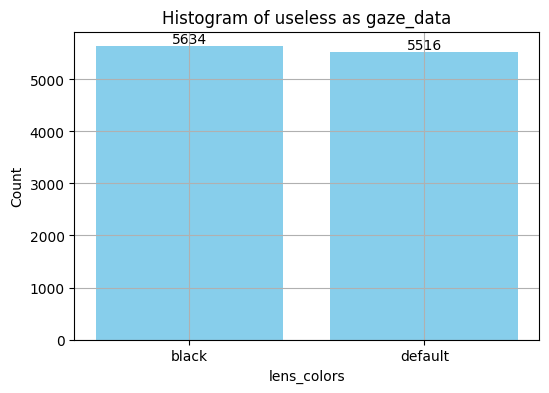

In [26]:
seen_countsT = df1[df1['lens_seen'] == 'useless']['lens_color'].value_counts()
# seen_counts0 = df1_id_0[df1_id_0['lens_seen'] == 'useless']['lens_color'].value_counts()
# seen_counts1 = df1_id_1[df1_id_1['lens_seen'] == 'useless']['lens_color'].value_counts()
# categories = ['default', 'black']

# # 빈도 리스트 생성
# counts0 = [seen_counts0.get(cat, 0) for cat in categories]
# counts1 = [seen_counts1.get(cat, 0) for cat in categories]

# bar_width = 0.35
# index = np.arange(len(categories))

# 히스토그램 그리기
plt.figure(figsize=(6, 4))
bars = plt.bar(seen_countsT.index, seen_countsT.values, color='skyblue')
plt.xlabel('lens_colors')
plt.ylabel('Count')
plt.title('Histogram of useless as gaze_data')
plt.grid(True)

for bar, count in zip(bars, seen_countsT.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom')
plt.show()

# # 히스토그램 그리기
# plt.figure(figsize=(6, 4))
# bars0 = plt.bar(index - bar_width/2, counts0, bar_width, label='id_0', color='skyblue')
# bars1 = plt.bar(index + bar_width/2, counts1, bar_width, label='id_1', color='lightgreen')

# # 그래프 꾸미기
# plt.xlabel('lens_colors')
# plt.ylabel('Count')
# plt.title('Histogram of useless as gaze_data by id')
# plt.xticks(index, categories)
# plt.grid(True)
# plt.legend()

# # 각 막대 위에 값 표시
# for bars in [bars0, bars1]:
#     for bar in bars:
#         height = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2, height, str(int(height)), ha='center', va='bottom')

# plt.show()

In [30]:
rows = df1[(df1['left_eye_width'] <= 10)]
# print(rows)

for index,row in rows.iterrows():
    img_path = row['img_path'].replace('data','flmk')
    img = cv2.imread(img_path)
    x1,y1 = row['left_center_landmark']
    x2,y2 = row['right_center_landmark']
    cv2.circle(image, (x1, y1), 2, (0,255,0), -1)
    cv2.circle(image, (x2, y2), 2, (0,255,0), -1)
    
    cv2.imshow('Image with Polygon', img)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [49]:
sample_label = 'Z:\\SAI\\data\\IR\\labeldata\\id_10\\id_10_case50_5.cam_rearview.f_1.info.json'
sample_img = 'Z:\\SAI\\data\\IR\\rawdata\\id_10\\id_10_case50_5.cam_rearview.f_1.rgb.png'

In [50]:
with open(sample_label,  'r', encoding='utf-8') as f:
    data = json.load(f)

screen_space_positions = {}
landmarks = data["landmarks"]["ibug68"]

for name, landmark in enumerate(landmarks):

    screen_space_pos = landmark["screen_space_pos"]
    screen_space_positions[f'{name}'] = screen_space_pos
    
left_center_x = int(((screen_space_positions['43'][0]*w)+(screen_space_positions['46'][0]*w))/2)
left_center_y = int(((screen_space_positions['43'][1]*h)+(screen_space_positions['46'][1]*h))/2)
right_center_x = int(((screen_space_positions['37'][0]*w)+(screen_space_positions['40'][0]*w))/2)
right_center_y = int(((screen_space_positions['37'][1]*h)+(screen_space_positions['40'][1]*h))/2)

In [51]:
import cv2
import numpy as np

# 이미지 로드 (예시로 이미지 파일 경로를 'image.jpg'로 가정)
image = cv2.imread(sample_img)

# gaze_values 데이터 (예시 데이터 사용)
gaze_values = data['gaze_values']
gaze_target = data['gaze_target']['target_name']

# 눈의 중심점 (예시로 눈의 위치를 설정)
eye_right_center = (right_center_x, right_center_y)
eye_left_center = (left_center_x, left_center_y)

# gaze_vector를 기반으로 화살표를 그리는 함수
def draw_gaze_vector(image, eye_center, gaze_vector, scale=100):
    end_point = (
        int(eye_center[0] + gaze_vector[0] * scale),
        int(eye_center[1] - gaze_vector[1] * scale)
    )
    cv2.arrowedLine(image, eye_center, end_point, (0, 255, 0), 2, tipLength=0.3)

# 오른쪽 눈의 gaze_vector 그리기
draw_gaze_vector(image, eye_right_center, gaze_values["eye_right"]["gaze_vector"])

# 왼쪽 눈의 gaze_vector 그리기
draw_gaze_vector(image, eye_left_center, gaze_values["eye_left"]["gaze_vector"])

# 결과 이미지 출력
print(gaze_target)
cv2.imshow('Gaze Visualization', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


none
